In [5]:
import mdtraj as md
from ase import Atoms
import nglview as nv
import networkx as nx

import torch
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGPooling, InnerProductDecoder
import torch_geometric.data as data
from torch_geometric.utils.convert import to_networkx

import numpy as np
import matplotlib.pyplot as plt


In [6]:
# loading the xtc and gro file into mdtraj
# traj = md.load('../../xtc_files/1000eql2.xtc', top='../../xtc_files/conf.gro')
traj = md.load('../../../xtc_files/1000_eql2.xtc', top='../../../xtc_files/conf.gro')

In [7]:
# creating the frame feature matrix
nframes = traj.xyz.shape[0]
natoms=traj.topology.residue(0).n_atoms
nmols=traj.topology.n_residues
frame_feature=[]
for i in range(nframes):
    com_pos=[] # position of Center of Mass of each molecule
    for res in range(nmols):
        com_pos.append(traj.xyz[i][res*natoms:(res+1)*natoms].mean(axis=0))
    frame_feature.append(com_pos)
frame_feature=np.array(frame_feature)
print(frame_feature.shape)

(1001, 592, 3)


In [8]:
# creating the edge index matrix
cutoff=0.5
all_edge_list=[]
for i in range(nframes):
    fromlist=[]
    tolist=[]
    for j in range(nmols):
        for k in range(j+1,nmols):
            if np.linalg.norm(frame_feature[i][j]-frame_feature[i][k])<cutoff:
                fromlist.append(j)
                tolist.append(k)
                tolist.append(j)
                fromlist.append(k)
    edgelist=np.array([fromlist,tolist]).astype(np.int64)
    all_edge_list.append(edgelist)
print(len(all_edge_list))

1001


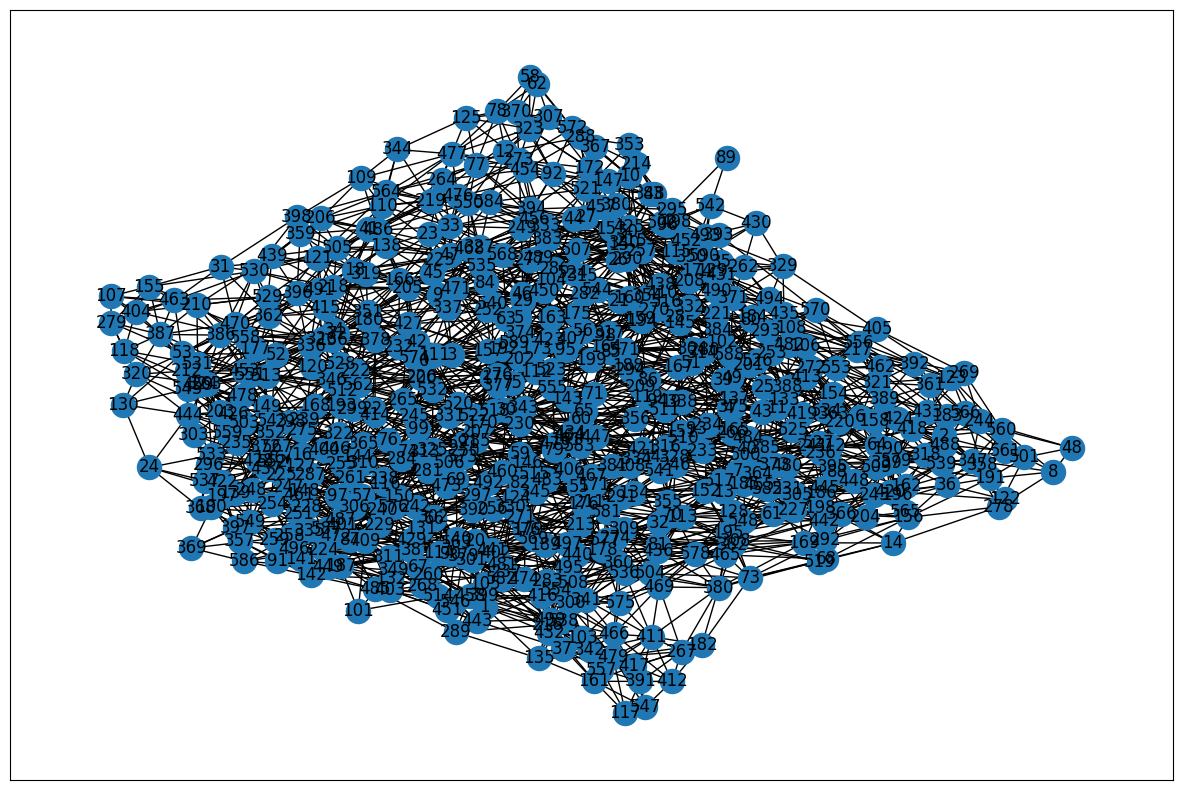

In [9]:
def convert_to_adj(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

def convert_to_edge_index(adj):
    edge_index = adj.nonzero().t()
    return edge_index
frame = 10
plt.figure(figsize=(15,10))
adj_binary = convert_to_adj(all_edge_list[frame], num_nodes=592)
indices = torch.where(adj_binary)
G = nx.Graph()
edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
G.add_edges_from(edges)
nx.draw_networkx(G)

In [10]:
graphs = []
for frame in range(nframes):
    g = data.Data(x=torch.tensor(frame_feature[frame]).float(), edge_index=torch.tensor(all_edge_list[frame]).long(), y=torch.tensor([0]))
    graphs.append(g)

print(graphs[0])

Data(x=[592, 3], edge_index=[2, 7986], y=[1])


In [11]:
# import model.
from model import *

In [12]:
input_dim = graphs[0].num_features
output_dim = 2
lr=1e-4
epochs=100
batch_size=1
model=VGAE(VariationalGCNEncoder(input_dim, output_dim),
           VariationalGCNDecoder(output_dim,input_dim))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [13]:
from pytorch3d.loss import chamfer_distance

In [14]:
train_loader_set = DataLoader(graphs[:int(nframes*0.6)], batch_size=batch_size, shuffle=True)
validation_loader_set = DataLoader(graphs[int(nframes*0.6):int(nframes*0.8)], batch_size=batch_size, shuffle=True)
test_loader_set = DataLoader(graphs[int(nframes*0.8):], batch_size=batch_size, shuffle=True)

In [15]:
for data in train_loader_set:
    z,encoded_edgeindex=model.encode(data.x,data.edge_index)
    decodedx,decoded_edgeindex=model.decode(z,encoded_edgeindex)
    # print(data)
    print(decodedx)
    print("data.x")
    print(data.x)
    print("sizes")
    print(decodedx.size())
    print(data.x.size())

tensor([[-0.0955,  0.1103, -0.1148],
        [-0.1239,  0.1192, -0.1071],
        [-0.0171,  0.1257, -0.1526],
        ...,
        [-0.2071,  1.1349, -0.2697],
        [-0.0014,  0.0331, -0.0329],
        [-0.1653,  0.6196, -0.2671]], grad_fn=<SiluBackward0>)
data.x
tensor([[0.4162, 1.9908, 1.6683],
        [1.8343, 0.8068, 1.6033],
        [0.6168, 0.2862, 2.1843],
        ...,
        [1.5300, 2.4968, 0.9000],
        [0.4783, 0.1638, 0.3143],
        [1.5213, 1.3870, 1.7403]])
sizes
torch.Size([592, 3])
torch.Size([592, 3])
tensor([[-0.0588,  0.4415, -0.2553],
        [-0.2758,  0.2127, -0.0905],
        [-0.1524,  0.3287, -0.1989],
        ...,
        [-0.1635,  0.2004, -0.1691],
        [-0.0795,  0.1588, -0.1670],
        [-0.1642,  0.9030, -0.2783]], grad_fn=<SiluBackward0>)
data.x
tensor([[1.4048, 0.4530, 0.5880],
        [1.3445, 2.2035, 2.5255],
        [2.6315, 1.1750, 2.1873],
        ...,
        [2.2352, 0.6183, 2.0598],
        [1.0363, 0.3618, 2.1037],
        [2.6480

In [16]:
lossFxn = torch.nn.MSELoss()
def train():
    model.train()
    model.zero_grad()
    model.float()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    closs_all=0
    for data in train_loader_set:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        # print(closs[0])
        closs=closs[0]
        closs=torch.tensor(closs, dtype=torch.float32)
        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        # loss = FeatureLoss + EdgeLoss 
        loss = FeatureLoss + EdgeLoss + closs
        loss = loss 
        closs_all+=float(closs)
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        kl_loss_all += float(model.kl_loss()/data.num_nodes)

        loss.backward()
        optimizer.step()

        

    return loss_all / len(train_loader_set.dataset),closs_all/len(train_loader_set.dataset), feature_loss_all / len(train_loader_set.dataset), edge_loss_all / len(train_loader_set.dataset), kl_loss_all / len(train_loader_set.dataset)

In [17]:
# writing a vakidation function
def validate():
    model.eval()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    closs_all=0
    for data in validation_loader_set:
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        # print(closs[0])
        closs=closs[0]
        closs=torch.tensor(closs, dtype=torch.float32)
        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        # loss = FeatureLoss + EdgeLoss 
        loss = FeatureLoss + EdgeLoss + closs
        loss = loss 
        closs_all+=float(closs)
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        kl_loss_all += float(model.kl_loss()/data.num_nodes)

    return loss_all / len(validation_loader_set.dataset),closs_all/len(validation_loader_set.dataset), feature_loss_all / len(validation_loader_set.dataset), edge_loss_all / len(validation_loader_set.dataset), kl_loss_all / len(validation_loader_set.dataset)

In [18]:
lossFxn = torch.nn.MSELoss()
def test():
    model.eval()
    model.zero_grad()
    model.float()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    type_loss_all = 0
    closs_all=0
    for data in test_loader_set:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index= model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        # print(closs[0])
        closs=closs[0]
        closs=torch.tensor(closs, dtype=torch.float32)
        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        loss = FeatureLoss + EdgeLoss+closs 
        closs_all+=float(closs)
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        

    return loss_all / len(test_loader_set.dataset), closs_all/len(test_loader_set.dataset),feature_loss_all / len(test_loader_set.dataset), edge_loss_all / len(test_loader_set.dataset), kl_loss_all / len(test_loader_set.dataset)

In [19]:
total_losses = []
feature_losses = []
edge_losses = []
kl_losses = []
val_total_losses = []
val_feature_losses = []
val_edge_losses = []
val_kl_losses = []
test_total_losses = []
test_feature_losses = []
test_edge_losses = []
test_kl_losses = []
cd_losses=[]
val_cd_losses=[]
test_cd_losses=[]
for epoch in range(1, epochs+ 1):
    total_loss, cd_loss,feature_loss, edge_loss, kl_loss = train()
    val_total_loss, val_cd_loss,val_feature_loss, val_edge_loss, val_kl_loss = validate()
    test_total_loss, test_cd_loss,test_feature_loss, test_edge_loss, test_kl_loss = test()
    print(f'Epoch: {epoch:03d}')
    print(f'TRAIN : Total Loss: {total_loss:.4f}, CD Loss : {cd_loss:.4f}, Feature Loss: {feature_loss:.4f}, Edge Loss: {edge_loss:.4f}')
    print(f'VALIDATE : Total Loss: {val_total_loss:.4f}, CD Loss : {val_cd_loss:.4f},Feature Loss: {val_feature_loss:.4f}, Edge Loss: {val_edge_loss:.4f}')
    print(f'TEST : Total Loss: {test_total_loss:.4f},CD Loss : {test_cd_loss:.4f}, Feature Loss: {test_feature_loss:.4f}, Edge Loss: {test_edge_loss:.4f}')
    total_losses.append(total_loss)
    feature_losses.append(feature_loss)
    edge_losses.append(edge_loss)
    kl_losses.append(kl_loss)
    val_total_losses.append(val_total_loss)
    val_feature_losses.append(val_feature_loss)
    val_edge_losses.append(val_edge_loss)
    val_kl_losses.append(val_kl_loss)
    test_total_losses.append(test_total_loss)
    test_feature_losses.append(test_feature_loss)
    test_edge_losses.append(test_edge_loss)
    test_kl_losses.append(test_kl_loss)
    cd_losses.append(cd_loss)
    val_cd_losses.append(val_cd_loss)   
    test_cd_losses.append(test_cd_loss) 
    

/tmp/ipykernel_17268/1287167025.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closs=torch.tensor(closs, dtype=torch.float32)
/tmp/ipykernel_17268/368484634.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closs=torch.tensor(closs, dtype=torch.float32)
/tmp/ipykernel_17268/3817500453.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closs=torch.tensor(closs, dtype=torch.float32)


Epoch: 001
TRAIN : Total Loss: 7.5449, CD Loss : 5.4058, Feature Loss: 2.1391, Edge Loss: 0.0000
VALIDATE : Total Loss: 7.3735, CD Loss : 5.3880,Feature Loss: 1.9856, Edge Loss: 0.0000
TEST : Total Loss: 7.3896,CD Loss : 5.3990, Feature Loss: 1.9905, Edge Loss: 0.0000
Epoch: 002
TRAIN : Total Loss: 6.7636, CD Loss : 4.8827, Feature Loss: 1.8810, Edge Loss: 0.0000
VALIDATE : Total Loss: 6.1837, CD Loss : 4.5181,Feature Loss: 1.6656, Edge Loss: 0.0000
TEST : Total Loss: 6.1980,CD Loss : 4.5280, Feature Loss: 1.6699, Edge Loss: 0.0000
Epoch: 003
TRAIN : Total Loss: 5.5920, CD Loss : 4.0472, Feature Loss: 1.5447, Edge Loss: 0.0000
VALIDATE : Total Loss: 4.9186, CD Loss : 3.5988,Feature Loss: 1.3198, Edge Loss: 0.0000
TEST : Total Loss: 4.9316,CD Loss : 3.6081, Feature Loss: 1.3235, Edge Loss: 0.0000
Epoch: 004
TRAIN : Total Loss: 4.2083, CD Loss : 3.0286, Feature Loss: 1.1797, Edge Loss: 0.0000
VALIDATE : Total Loss: 3.4265, CD Loss : 2.4929,Feature Loss: 0.9336, Edge Loss: 0.0000
TEST : T

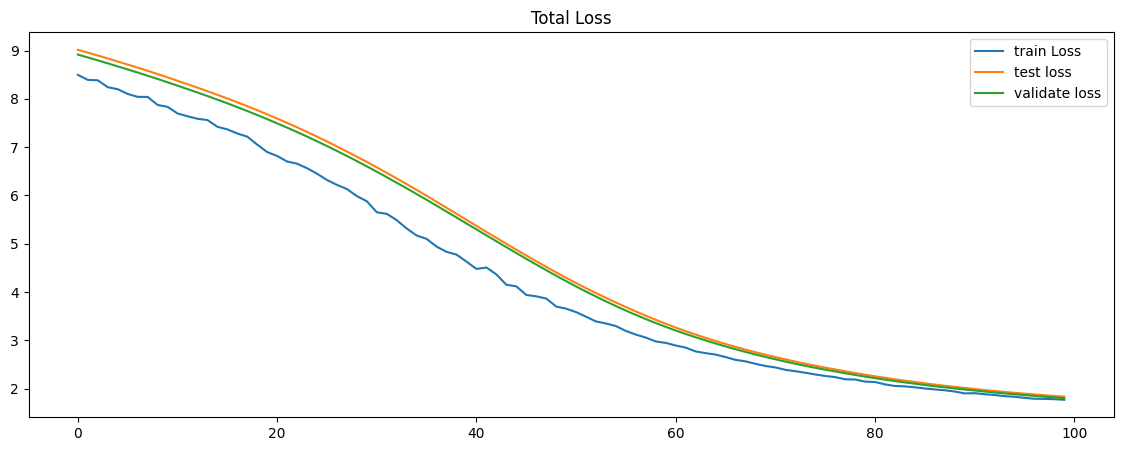

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(total_losses, label='train Loss')
plt.plot(test_total_losses, label='test loss')
plt.plot(val_total_losses, label='validate loss')
plt.legend()
plt.title('Total Loss')
plt.show()

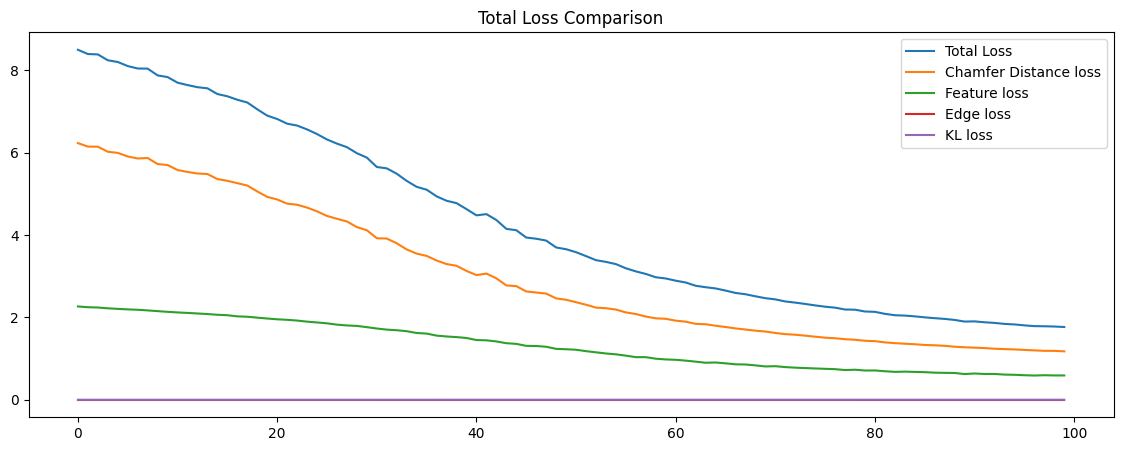

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(total_losses, label='Total Loss')
plt.plot(cd_losses, label='Chamfer Distance loss')
plt.plot(feature_losses, label='Feature loss')
plt.plot(edge_losses, label='Edge loss')
plt.plot(kl_losses, label='KL loss')
plt.legend()
plt.title('Total Loss Comparison')
plt.show()

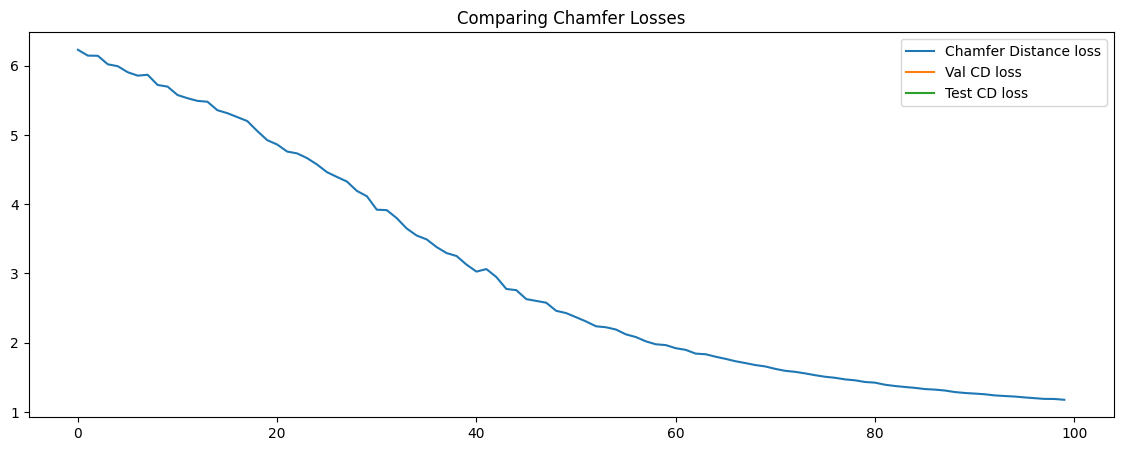

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(cd_losses, label='Chamfer Distance loss')
plt.plot(val_cd_loss, label='Val CD loss')
plt.plot(test_cd_loss, label='Test CD loss')
plt.legend()
plt.title('Comparing Chamfer Losses')
plt.show()

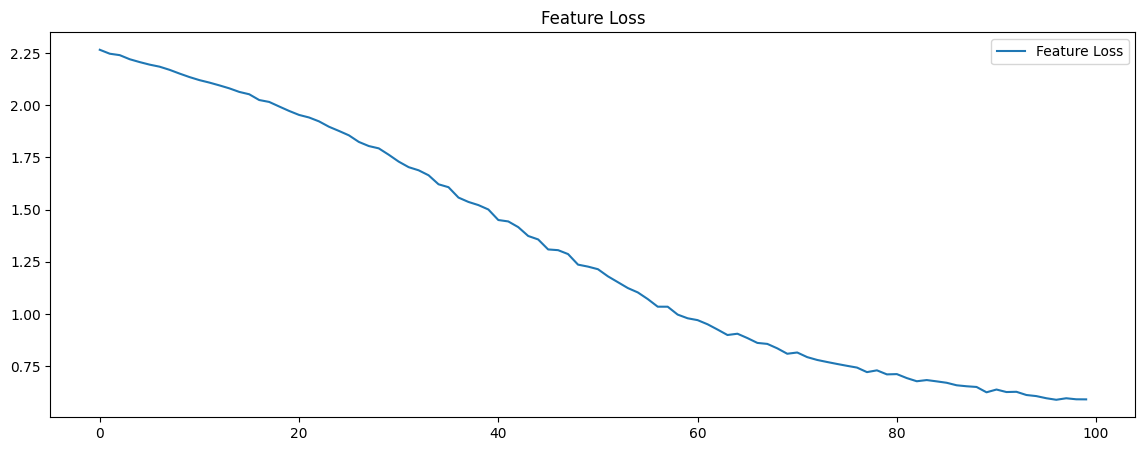

In [ ]:

plt.figure(figsize=(14, 5))
plt.plot(feature_losses, label='Feature Loss')
plt.legend()
plt.title('Feature Loss')
plt.show()